In [1]:
import tensorflow as tf
import os

from assets.one_mask.data_generator import DR_Generator
from assets.one_mask.models import SMD_Unet 
from assets.one_mask.trainer_withCE import Trainer

In [2]:
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/FGADR/Seg-set'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

generator_args = {
    'dir_path':'../data/FGADR/Seg-set/Original_Images/',
    'mask_path':mask_paths,
    'use_mask':True,
    'img_size':(512, 512),  
    'batch_size':4, # 8로 하면 바로 OOM 뜸
    'dataset':'FGADR', # FGADR or EyePacks
    'use_3channel':True,
    'CLAHE_args':None
}

tr_fgadr_gen = DR_Generator(start_end_index=(0, 1108), is_train=True, **generator_args)
val_fgadr_gen = DR_Generator(start_end_index=(1108, 1660), is_train=False, **generator_args)
ts_fgadr_gen = DR_Generator(start_end_index=(1660, 1840), is_train=False, **generator_args)

# tr_fgadr_gen = DR_Generator(start_end_index=(0, 1292), is_train=True, **generator_args)
# val_fgadr_gen = DR_Generator(start_end_index=(1292, 1476), is_train=False, **generator_args)
# ts_fgadr_gen = DR_Generator(start_end_index=(1476, 1842), is_train=False, **generator_args)

# tr_fgadr_gen = DR_Generator(start_end_index=(0, 30000), is_train=True, **generator_args)
# val_fgadr_gen = DR_Generator(start_end_index=(30000, 31000), is_train=False, **generator_args)

In [3]:
model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3)
model.load_weights("../models/one_mask/New/3_3channel_CE_1_alpha01_lr0001/23")

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 

trainer_args = {
    'model':model,
    'epochs':50,
    'optimizer':optimizer,
    'for_recons':False,   # pretraining을 할지 말지 (true = recons만 학습 한다.)
    'alpha':0.1,           # loss를 구할때 mask_loss는 알파 * recons_loss + (1 - 알파 * mask_loss)
    'beta':None,
    'first_epoch':24,
    'file_name':"history/one_mask/New/3_3channel_CE_1_alpha01_lr0001.txt",
    'save_model_path':"../models/one_mask/New/3_3channel_CE_1_alpha01_lr0001",
    'add_noise':False,
    'bce_weight':1
}
trainer = Trainer(**trainer_args)

trainer.train(train_dataset=tr_fgadr_gen,
              val_dataset=val_fgadr_gen
             )


Epoch 24/50


ValueError: could not broadcast input array from shape (512,512,3) into shape (512,512)

# 모델 결과 시각화

In [2]:
from assets.one_mask.utils import parse_history_text
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

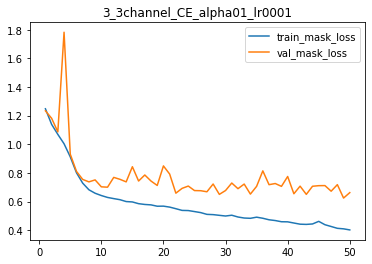

In [3]:
history = parse_history_text('history/one_mask/New/3_3channel_CE_alpha01_lr0001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='train_mask_loss')
plt.plot(history['epoch'], history['val_mask_loss'], label='val_mask_loss')

plt.title('3_3channel_CE_alpha01_lr0001')
plt.legend()
plt.show()

In [ ]:
history = parse_history_text('history/one_mask/5_1_pretraining_3channel_addnoise_alpha01_lr00001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.001')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.001')


history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr00001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.0001', linestyle='--')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.0001', linestyle='--')

plt.title('lr')
plt.legend()
plt.show()

# 평가지표

In [2]:
from assets.evaluation.evaluate_result import evaluate_main

generator_type = 'validation'  # 원하는 generator 타입 선택: 'train', 'validation', 또는 'test'
input_channel = 3         # 3channel은 3, 1channel은 1
use_3channel = True     # 3channel은 True, 1channel은 False
model_path = "../models/one_mask/New/3_1_3channel_alpha01_lr00001/8"  # 모델 경로 지정
result_df = evaluate_main(generator_type, model_path, input_channel, use_3channel)

100%|██████████| 138/138 [03:07<00:00,  1.36s/it]

CSV 파일 저장 완료: assets/evaluation/evaluation_results_csv/3_1_3channel_alpha01_lr00001_validation_evaluation_result.csv


In [32]:
import pandas as pd

result_df = pd.read_csv("assets/evaluation/evaluation_results_csv/3_1_3channel_alpha01_lr00001_validation_evaluation_result.csv")
#result_df = result_df["file_name"]
#result_df = result_df.iloc[:10]
#result_df

In [33]:
b_df = pd.read_csv("../data/FGADR/average_brightness.csv")

In [34]:
result_df.set_index("file_name", inplace=True)
b_df.set_index("file_name", inplace=True)

# join 메서드를 사용하여 두 데이터프레임을 합침
merged_df = result_df.join(b_df, how="inner")

merged_df.to_csv("merged_data.csv")

In [35]:
merged_df

,dice,iou,pr_auc,mae,brightness
file_name,,,,,
1221_3.png,8.816630e-01,0.788033,0.917700,0.000797,93.805126
1350_2.png,8.424954e-01,0.728034,0.872050,0.039518,88.514426
1452_3.png,8.419399e-01,0.727372,0.885659,0.020924,109.055558
1608_3.png,8.351476e-01,0.717199,0.881053,0.098473,115.429267
1134_1.png,8.229367e-01,0.699133,0.821815,0.029391,80.361255
...,...,...,...,...,...
1128_1.png,7.145567e-11,0.000000,NaN,0.005339,72.240638
1340_1.png,6.647828e-11,0.000000,NaN,0.005738,67.015753
1373_3.png,5.832771e-11,0.000000,NaN,0.006540,108.141068


In [36]:
merged_df = merged_df.iloc[420:520]

count_b = len(merged_df[merged_df["brightness"] >= 80])
mean_b = merged_df["brightness"].mean()
print(count_b)
print(mean_b)


47
81.84554670410157


# Prediction 결과 시각화

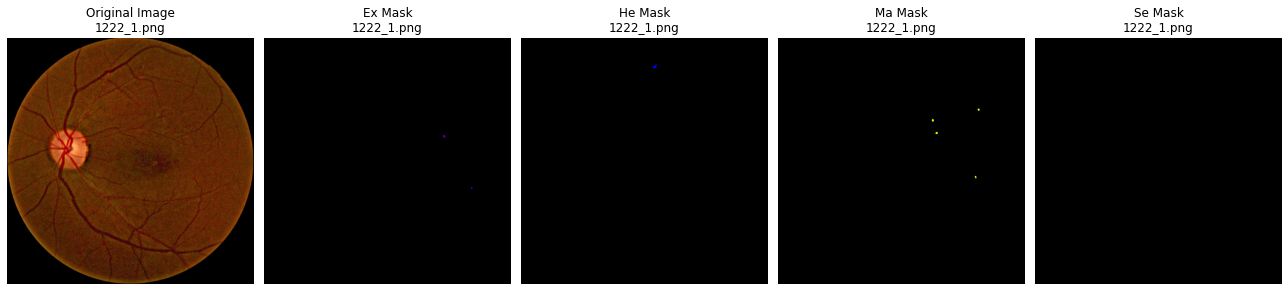

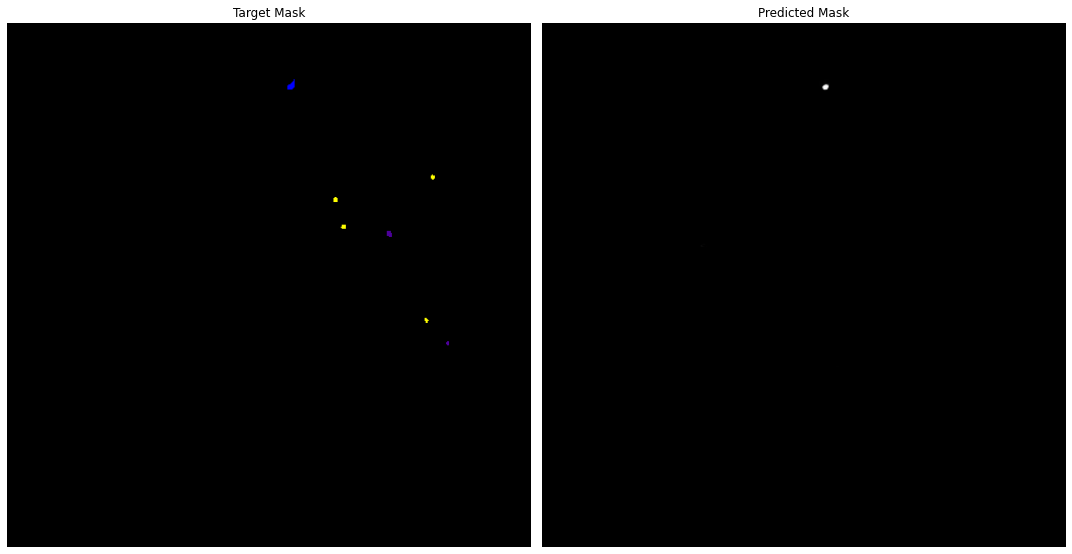

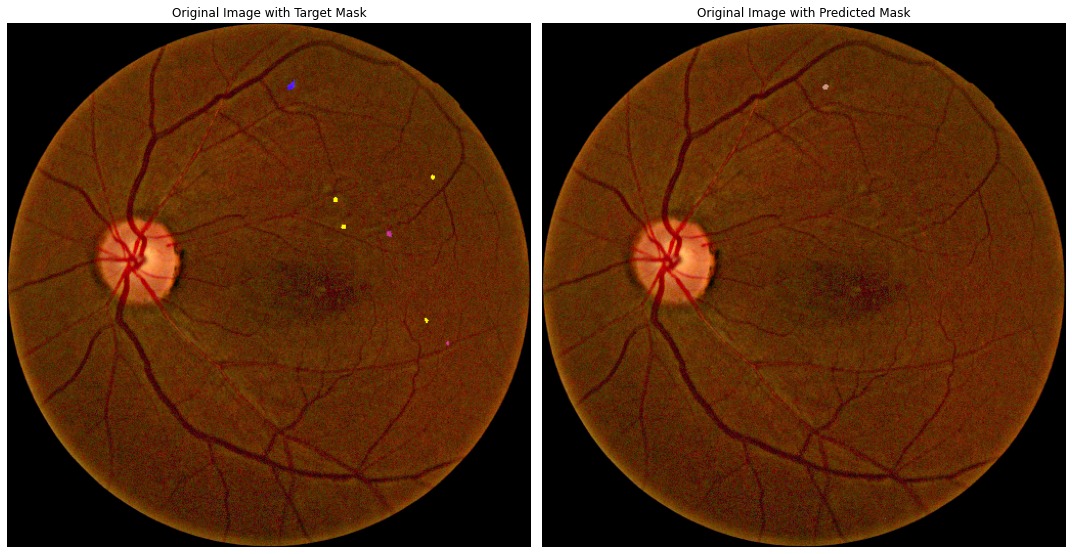

In [11]:
from assets.evaluation.evaluation_visual import visualize_segmentation_results

image_filenames = ["1222_1.png"]  # 원하는 이미지 파일명으로 수정
#image_filenames = result_df

mask_dir = '../data/FGADR/Seg-set'
image_dir = '../data/FGADR/Seg-set/Original_Images/'
#image_dir = '../data/FGADR/'

model_path = "../models/one_mask/New/3_3channel_CE_alpha01_lr0001/49"
visualize_segmentation_results(image_filenames, model_path, mask_dir, image_dir)